## Ex3 - Autoencoders

In [1]:
%matplotlib inline

import helper
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### Hyperparameters

In [2]:
epochs = 10
batch_size = 200
n_batches = 5
noise_factor = 35
learning_rate = 0.001
do_preprocess = False

### Prepare the dataset

In [3]:
cifar10_dataset_url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
cifar10_dataset_folder_path = 'cifar-10-batches-py'
tar_gz_path = 'cifar-10-python.tar.gz'

helper.download_dataset(cifar10_dataset_url, cifar10_dataset_folder_path, tar_gz_path) 
if do_preprocess:
    helper.preprocess_and_save_data(cifar10_dataset_folder_path, noise_factor, n_batches)

Cifar-10 dataset found


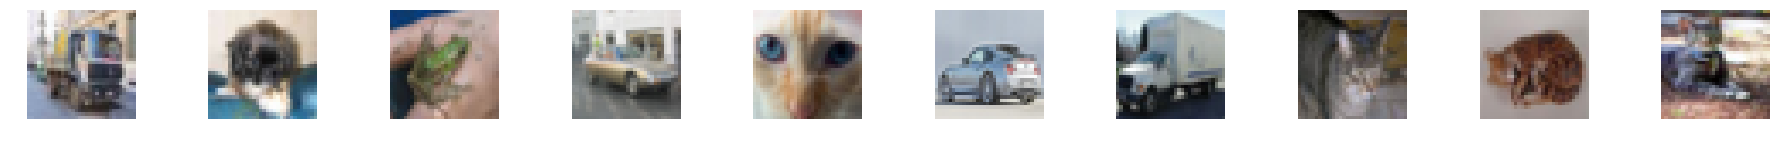

In [4]:
features, labels = helper.load_cfar10_batch(cifar10_dataset_folder_path, random.randint(1, n_batches))
valid_features, valid_noisy, _ = helper.load_preprocess_validation()[:10]

plt.figure(figsize=(32, 2))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    plt.axis('off')
    plt.imshow(features[i + random.randint(0, len(features) - 10)])

### Build the network

In [5]:
inputs_ = tf.placeholder(tf.float32, (None, 32, 32, 3), name='inputs')
targets_ = tf.placeholder(tf.float32, (None, 32, 32, 3), name='targets')

conv1 = tf.layers.conv2d(inputs_, 32, (3,3), padding='same', activation=tf.nn.relu)
maxpool1 = tf.layers.max_pooling2d(conv1, (2,2), (2,2), padding='same')
conv2 = tf.layers.conv2d(maxpool1, 32, (3,3), padding='same', activation=tf.nn.relu)
maxpool2 = tf.layers.max_pooling2d(conv2, (2,2), (2,2), padding='same')
conv3 = tf.layers.conv2d(maxpool2, 16, (3,3), padding='same', activation=tf.nn.relu)
encoded = tf.layers.max_pooling2d(conv3, (2,2), (2,2), padding='same')

upsample1 = tf.image.resize_nearest_neighbor(encoded, (7,7))
conv4 = tf.layers.conv2d(upsample1, 16, (3,3), padding='same', activation=tf.nn.relu)
upsample2 = tf.image.resize_nearest_neighbor(conv4, (14,14))
conv5 = tf.layers.conv2d(upsample2, 32, (3,3), padding='same', activation=tf.nn.relu)
upsample3 = tf.image.resize_nearest_neighbor(conv5, (32,32))
conv6 = tf.layers.conv2d(upsample3, 32, (3,3), padding='same', activation=tf.nn.relu)

logits = tf.layers.conv2d(conv6, 3, (3,3), padding='same', activation=None)

decoded = tf.nn.sigmoid(logits, name='decoded')

loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=targets_, logits=logits)
cost = tf.reduce_mean(loss)
opt = tf.train.AdamOptimizer(learning_rate).minimize(cost)

### Train the network

In [6]:
sess = tf.Session()

In [7]:
print('Training...')
sess.run(tf.global_variables_initializer())
for e in range(epochs):
    for batch_i in range(1, n_batches + 1):
        for features, noisy_features, _ in helper.load_preprocess_training_batch(batch_i, batch_size):
            batch_cost, _ = sess.run([cost, opt], feed_dict={inputs_: noisy_features, targets_: features})
    print("Epoch: {}/{}...".format(e + 1, epochs), "Training loss: {:.4f}".format(batch_cost))
    reconstructed = sess.run(decoded, feed_dict={inputs_: valid_noisy.reshape((10, 32, 32, 3))})
    helper.show_images(valid_features, reconstructed)

Training...
('Epoch: 1/10...', 'Training loss: 0.5945')


ValueError: cannot reshape array of size 15360000 into shape (10,32,32,3)

### Test the network

In [ ]:
in_imgs, noisy_imgs, _ = helper.load_preprocess_testing()
noisy_imgs = noisy_imgs[:10]

reconstructed = sess.run(decoded, feed_dict={inputs_: noisy_imgs.reshape((10, 32, 32, 3))})

helper.show_images(in_imgs, reconstructed)